### Project Setup and Imports

In [1]:
base_path = "C:/deep1/cat_v1"
import os, shutil, re, copy, random, time, sys, base64
from glob import glob
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sn
import tqdm
from tqdm.notebook import tqdm as tqdm_notebook
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import sklearn
from sklearn.model_selection import StratifiedKFold, KFold, ParameterGrid
from sklearn.metrics import confusion_matrix

### Environment and Version Info

In [2]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"  

print('torch=='+torch.__version__)
print('torchvision=='+torchvision.__version__)
print('numpy=='+np.__version__)
print('pandas=='+pd.__version__)
print('matplotlib=='+mpl.__version__)
print('tqdm=='+tqdm.__version__)
print('sklearn=='+sklearn.__version__)
print('seaborn=='+sn.__version__)

torch==1.4.0+cpu
torchvision==0.5.0+cpu
numpy==1.15.4
pandas==0.24.2
matplotlib==3.0.3
tqdm==4.38.0
sklearn==0.20.3
seaborn==0.8.1


### Load and Preprocess Dataset

In [11]:
breeds = {
    1: 'bengal',
    2: 'domestic_shorthair',
    3: 'maine_coon',
    4: 'ragdoll',
    5: 'siamese',
}
base_path = "C:/deep1/cat_v1"
target_size = (224, 224)  
image_data, labels = [], []
image_count = 0
for breed in os.listdir(base_path):
    breed_path = os.path.join(base_path, breed)
    if os.path.isdir(breed_path):
        for img_file in os.listdir(breed_path):
            img_path = os.path.join(breed_path, img_file)
            try:
                img = Image.open(img_path).convert('RGB').resize(target_size)
                img_array = np.array(img) / 255.0  
                image_data.append(img_array)
                labels.append(breed)
                image_count += 1
            except Exception as e:
                print(f" Could not load image: {img_path} — {e}")
print(f"Loaded {image_count} images across {len(set(labels))} breeds.")

 Could not load image: C:/deep1/cat_v1\test\bengal — [Errno 13] Permission denied: 'C:/deep1/cat_v1\\test\\bengal'
 Could not load image: C:/deep1/cat_v1\test\domestic_shorthair — [Errno 13] Permission denied: 'C:/deep1/cat_v1\\test\\domestic_shorthair'
 Could not load image: C:/deep1/cat_v1\test\maine_coon — [Errno 13] Permission denied: 'C:/deep1/cat_v1\\test\\maine_coon'
 Could not load image: C:/deep1/cat_v1\test\ragdoll — [Errno 13] Permission denied: 'C:/deep1/cat_v1\\test\\ragdoll'
 Could not load image: C:/deep1/cat_v1\test\siamese — [Errno 13] Permission denied: 'C:/deep1/cat_v1\\test\\siamese'
 Could not load image: C:/deep1/cat_v1\train\bengal — [Errno 13] Permission denied: 'C:/deep1/cat_v1\\train\\bengal'
 Could not load image: C:/deep1/cat_v1\train\domestic_shorthair — [Errno 13] Permission denied: 'C:/deep1/cat_v1\\train\\domestic_shorthair'
 Could not load image: C:/deep1/cat_v1\train\maine_coon — [Errno 13] Permission denied: 'C:/deep1/cat_v1\\train\\maine_coon'
 Could

###  📊 Visualize Dataset Distribution

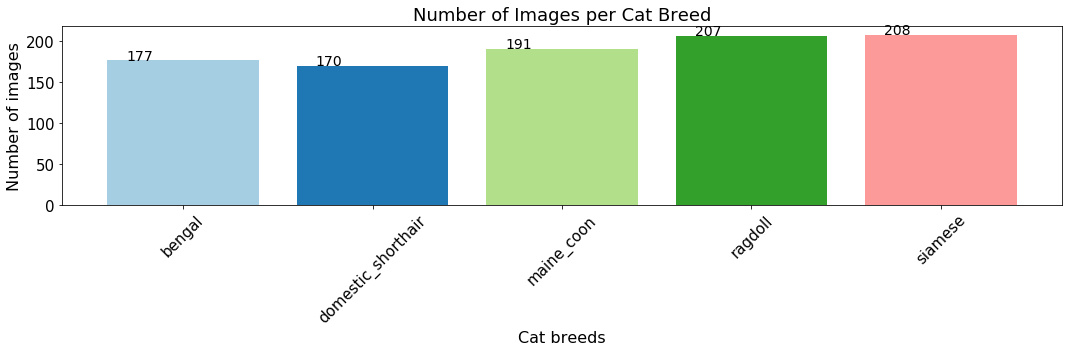

In [12]:
from collections import Counter
breed_counts = Counter(labels)
sorted_breeds = sorted(breed_counts.keys())
counts = [breed_counts[breed] for breed in sorted_breeds]
fig, ax = plt.subplots(figsize=(15, 5))
bars = ax.bar(sorted_breeds, counts, color=plt.cm.Paired(np.arange(len(counts))))
ax.set_xticklabels(sorted_breeds, rotation=45)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Cat breeds', fontsize=16)
ax.set_ylabel('Number of images', fontsize=16)
for p in bars:
    ax.annotate(str(p.get_height()), (p.get_x() + 0.1, p.get_height() + 0.5), size=14)
plt.title("Number of Images per Cat Breed", fontsize=18)
plt.tight_layout()
plt.show()

### 🧪 Train-Test Split

In [13]:
from sklearn.model_selection import train_test_split
image_data = np.array(image_data)
labels = np.array(labels)
X_train, X_test, y_train, y_test = train_test_split(
    image_data, labels, test_size=0.2, stratify=labels, random_state=42
)
print(f" Train set: {len(X_train)} images")
print(f" Test set: {len(X_test)} images")

 Train set: 762 images
 Test set: 191 images


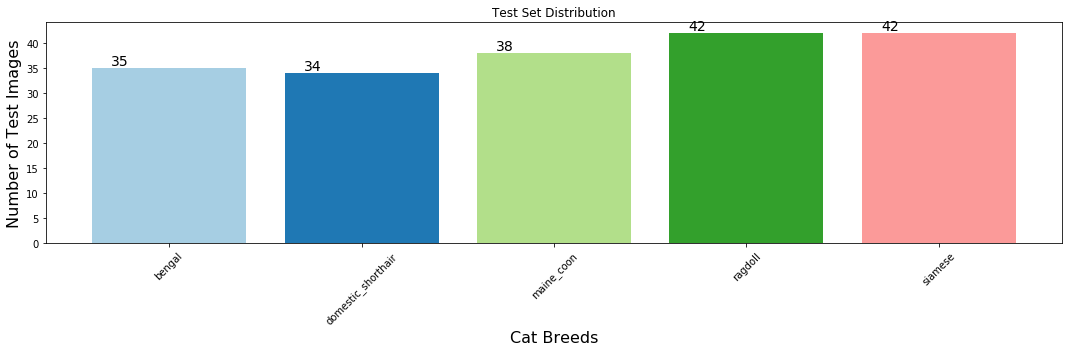

In [14]:
from collections import Counter
import matplotlib.pyplot as plt
test_counts = Counter(y_test)
sorted_breeds = sorted(test_counts.keys())
counts = [test_counts[breed] for breed in sorted_breeds]
fig, ax = plt.subplots(figsize=(15, 5))
bars = ax.bar(sorted_breeds, counts, color=plt.cm.Paired(np.arange(len(counts))))
ax.set_xticklabels(sorted_breeds, rotation=45)
ax.set_xlabel("Cat Breeds", fontsize=16)
ax.set_ylabel("Number of Test Images", fontsize=16)
for p in bars:
    ax.annotate(str(p.get_height()), (p.get_x() + 0.1, p.get_height() + 0.5), size=14)

plt.title("Test Set Distribution")
plt.tight_layout()
plt.show()


In [15]:
split_base = "C:/deep1/cat_v1"
train_dir = os.path.join(split_base, "train")
test_dir = os.path.join(split_base, "test")
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

def create_train_test_dirs(base_path):
    train_dir = os.path.join(base_path, 'train')
    test_dir = os.path.join(base_path, 'test')
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)
    return train_dir, test_dir

def split_dataset(base_path, train_ratio=0.8):
    train_dir, test_dir = create_train_test_dirs(base_path)
    breed_dirs = [d for d in os.listdir(base_path) 
                 if os.path.isdir(os.path.join(base_path, d)) 
                 and d not in ['train', 'test']]
    for breed in breed_dirs:
        print(f"\nProcessing {breed}...")
        breed_path = os.path.join(base_path, breed)
        os.makedirs(os.path.join(train_dir, breed), exist_ok=True)
        os.makedirs(os.path.join(test_dir, breed), exist_ok=True)
        images = [f for f in os.listdir(breed_path) 
                 if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        random.shuffle(images)

        split_idx = int(len(images) * train_ratio)
        train_images = images[:split_idx]
        test_images = images[split_idx:]
        for img in train_images:
            src = os.path.join(breed_path, img)
            dst = os.path.join(train_dir, breed, img)
            shutil.copy2(src, dst)
            print(f"Copied {img} to train set")
        for img in test_images:
            src = os.path.join(breed_path, img)
            dst = os.path.join(test_dir, breed, img)
            shutil.copy2(src, dst)
            print(f"Copied {img} to test set")
        print(f"✓ {breed}: {len(train_images)} training images, {len(test_images)} test images")

if __name__ == "__main__":
    base_path = "cat_v1"  
    split_dataset(base_path)
    print("\nDataset split complete! ✨") 


Processing bengal...
Copied IMG_9518.jpg to train set
Copied 3eb7e9a7542bdead2c633e4a2b06a588.jpg to train set
Copied 1200px-Bangie_the_Bengal_Cat.jpg to train set
Copied Cutest-Bengal-Cat-Have-Gorgeous-Blue-Eyes.jpg to train set
Copied 1142194.jpg to train set
Copied nebss.jpg to train set
Copied ebe4dba7f07ec3734ec73da194467701.jpg to train set
Copied cool-bengal-cat-names.jpg to train set
Copied bengal-kitten-860995.jpg to train set
Copied 15658-Brown-spotted-Bengal-female-cat.jpg to train set
Copied bengal-esa-cat-mango-clinic.jpg to train set
Copied 5fba2bc61c502d3177e845b48807e38d.jpg to train set
Copied 22384097_10154807489365927_7732210437813358666_o.jpg to train set
Copied 00e79f939696ea0c095603154c4af840.jpg to train set
Copied bengal_cat_stock_20140324_1_by_furlined-d7kmoef.jpg to train set
Copied fullsizeoutput_4f30.jpg to train set
Copied maxresdefault-60.jpg to train set
Copied pexels-photo-326971.jpeg to train set
Copied Thor-Belgian-Bengal-Cat.jpg to train set
Copied 7

### 🔧 Initialization & Reproducibility

In [16]:
def seed_torch(seed=1029):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
seed_torch(42)

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### 📈 Metrics & Utilities

In [18]:
def accuracy(output, target, topk=(1,)):
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)
        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))
        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res
def save_model_state(model, path):
    torch.save(model.state_dict(), path)
def load_model_state(model, path):
    model.load_state_dict(torch.load(path))
    model = model.to(device)
    return model
def get_cv_result_per_epoch(history):
    cv_results = []
    for i,history_per_fold in enumerate(history):
        cv_result_per_epoch = []
        for j in range(len(history_per_fold[0])):
            cv_train_acc = 0.0
            cv_train_loss = 0.0
            cv_valid_acc = 0.0
            cv_valid_loss = 0.0
            cv_train_data_size = 0
            cv_valid_data_size = 0
            for k,history_per_epoch in enumerate(history_per_fold):
                cv_train_acc += history_per_epoch[j]['avg_train_acc']*history_per_epoch[j]['train_data_size']
                cv_train_loss += history_per_epoch[j]['avg_train_loss']*history_per_epoch[j]['train_data_size']
                cv_valid_acc += history_per_epoch[j]['avg_valid_acc']*history_per_epoch[j]['valid_data_size']
                cv_valid_loss += history_per_epoch[j]['avg_valid_loss']*history_per_epoch[j]['valid_data_size']
                cv_train_data_size += history_per_epoch[j]['train_data_size']
                cv_valid_data_size += history_per_epoch[j]['valid_data_size']
            cv_result_per_epoch.append({
                'params' : history_per_epoch[0]['params'],
                'epoch' : j+1,
                'cv_train_acc' : cv_train_acc/float(cv_train_data_size),
                'cv_train_loss' : cv_train_loss/float(cv_train_data_size),
                'cv_valid_acc' : cv_valid_acc/float(cv_valid_data_size),
                'cv_valid_loss' : cv_valid_loss/float(cv_valid_data_size)
            })
        cv_results.append(cv_result_per_epoch)
    return cv_results
def get_best_cv_result(cv_history):
    cv_results = get_cv_result_per_epoch(cv_history)
    best_cv_result = {}
    for cv_result_per_epoch in cv_results:
        for cv_result in cv_result_per_epoch:
            if not best_cv_result or cv_result['cv_valid_loss'] < best_cv_result['cv_valid_loss']:
                best_cv_result = cv_result

    return best_cv_result
def plot_cv_result(cv_history):
    cv_results = get_cv_result_per_epoch(cv_history)
    plot_params = []
    plot_valid_loss = []
    plot_valid_acc = []
    for cv_result in cv_results:
        plot_params.append(cv_result[0]['params'])
        plot_valid_loss.append([val['cv_valid_loss'] for val in cv_result ])
        plot_valid_acc.append([val['cv_valid_acc'] for val in cv_result ])
    x = np.arange(1,len(plot_valid_loss[0])+1)
    print('\n------------ Validation loss per epoch ------------')
    for i in range(len(plot_valid_loss)):
        plt.plot(x,plot_valid_loss[i],label=plot_params[i])
    plt.legend(loc="upper right")
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.show()
    fig, ax = plt.subplots(2, 2,figsize=(15,9))
    ax[0,0].plot(x,plot_valid_loss[0],label=plot_params[0])
    ax[0,0].plot(x,plot_valid_loss[1],label=plot_params[1])
    ax[0,0].legend(loc="upper right")
    ax[0,0].set_ylabel('loss')
    ax[0,0].set_xlabel('epochs')
    ax[0,1].plot(x,plot_valid_loss[2],label=plot_params[2])
    ax[0,1].plot(x,plot_valid_loss[3],label=plot_params[3])
    ax[0,1].legend(loc="upper right")
    ax[0,1].set_ylabel('loss')
    ax[0,1].set_xlabel('epochs')
    ax[1,0].plot(x,plot_valid_loss[0],label=plot_params[0])
    ax[1,0].plot(x,plot_valid_loss[2],label=plot_params[2])
    ax[1,0].legend(loc="upper right")
    ax[1,0].set_ylabel('loss')
    ax[1,0].set_xlabel('epochs')
    ax[1,1].plot(x,plot_valid_loss[1],label=plot_params[1])
    ax[1,1].plot(x,plot_valid_loss[3],label=plot_params[3])
    ax[1,1].legend(loc="upper right")
    ax[1,1].set_ylabel('loss')
    ax[1,1].set_xlabel('epochs')
    plt.show()
    print('\n------------ Validation accuracy per epoch at ------------')
    for i in range(len(plot_valid_acc)):
        plt.plot(x,plot_valid_acc[i],label=plot_params[i])
    plt.legend(loc="lower right")
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.show()
    fig, ax = plt.subplots(2, 2,figsize=(15,9))
    ax[0,0].plot(x,plot_valid_acc[0],label=plot_params[0])
    ax[0,0].plot(x,plot_valid_acc[1],label=plot_params[1])
    ax[0,0].legend(loc="lower right")
    ax[0,0].set_ylabel('accuracy')
    ax[0,0].set_xlabel('epochs')
    ax[0,1].plot(x,plot_valid_acc[2],label=plot_params[2])
    ax[0,1].plot(x,plot_valid_acc[3],label=plot_params[3])
    ax[0,1].legend(loc="lower right")
    ax[0,1].set_ylabel('accuracy')
    ax[0,1].set_xlabel('epochs')
    ax[1,0].plot(x,plot_valid_acc[0],label=plot_params[0])
    ax[1,0].plot(x,plot_valid_acc[2],label=plot_params[2])
    ax[1,0].legend(loc="lower right")
    ax[1,0].set_ylabel('accuracy')
    ax[1,0].set_xlabel('epochs')
    ax[1,1].plot(x,plot_valid_acc[1],label=plot_params[1])
    ax[1,1].plot(x,plot_valid_acc[3],label=plot_params[3])
    ax[1,1].legend(loc="lower right")
    ax[1,1].set_ylabel('accuracy')
    ax[1,1].set_xlabel('epochs')
    plt.show()
def plot_train_result(train_history):
    plot_params = []
    plot_train_loss = []
    plot_train_acc = []
    x = np.arange(1, len(train_history)+1)
    for hist in train_history:
        plot_train_loss.append(hist['avg_train_loss'])
        plot_train_acc.append(hist['avg_train_acc']*100)
    plt.plot(x,plot_train_loss)
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title('Training loss')
    plt.show()
    plt.plot(x,plot_train_acc)
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.title('Training accuracy')
    plt.show()

###  Image Transforms & Dataset Setup

In [19]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
image_transforms = {
    'train': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        normalize
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        normalize
    ])
}
augmented_image_transforms = {
    'train': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        normalize
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        normalize
    ])
}
train_directory = 'C:/deep1/cat_v1_split/train'
test_directory = 'C:/deep1/cat_v1_split/test'
assert os.path.exists(train_directory), f"Train directory not found: {train_directory}"
assert os.path.exists(test_directory), f"Test directory not found: {test_directory}"
data = {
    'train': datasets.ImageFolder(root=train_directory), 
    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])
}
idx_to_class = {val: key for key, val in data['test'].class_to_idx.items()}
train_images = [d[0] for d in tqdm_notebook(data['train'], desc='train_images')]
train_labels = [d[1] for d in tqdm_notebook(data['train'], desc='train_labels')]

### Visualize Transforms & Augmentations

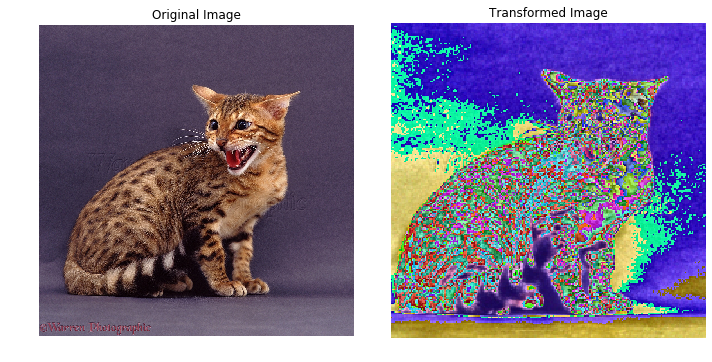

In [20]:
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
to_pil = transforms.ToPILImage()
img_path, label = data['train'].imgs[0]
ori_img = Image.open(img_path).convert("RGB")
trans_img_tensor = image_transforms['train'](ori_img)
trans_img = to_pil(trans_img_tensor)
f, axarr = plt.subplots(1, 2, figsize=(10, 5))
axarr[0].imshow(ori_img)
axarr[0].set_title('Original Image')
axarr[0].axis('off')
axarr[1].imshow(trans_img)
axarr[1].set_title('Transformed Image')
axarr[1].axis('off')
plt.tight_layout()
plt.show()

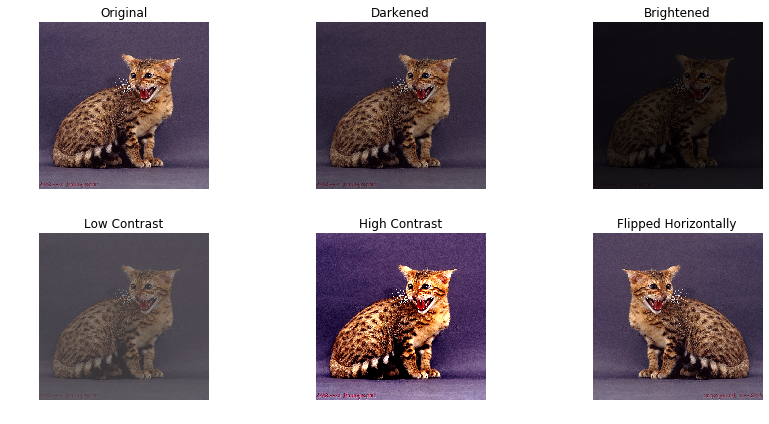

In [26]:
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load original image
img_path, _ = data['train'].imgs[0]
ori_img = Image.open(img_path).convert("RGB")

# Define transformations
transformations = {
    "Original": lambda x: x,
    "Darkened": transforms.ColorJitter(brightness=0.8),
    "Brightened": transforms.ColorJitter(brightness=1.2),
    "Low Contrast": transforms.ColorJitter(contrast=0.8),
    "High Contrast": transforms.ColorJitter(contrast=1.2),
    "Flipped Horizontally": transforms.RandomHorizontalFlip(p=1.0)
}

# Apply transforms
transformed_imgs = {name: transform(ori_img) for name, transform in transformations.items()}

# Plot results
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
axes = axes.flatten()

for ax, (title, img) in zip(axes, transformed_imgs.items()):
    ax.imshow(img)
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()


## Grid Search & Cross Validation function

In [27]:
def grid_search_cv(
    model,
    k_fold=5,
    epochs=10,
    hyperparameters={'batch_size': [32, 64], 'learning_rate': [1e-3, 1e-4]},
    transforms=image_transforms
):
    from PIL import Image
    from sklearn.model_selection import StratifiedKFold
    from sklearn.model_selection import ParameterGrid
    kFold = StratifiedKFold(n_splits=k_fold, shuffle=True, random_state=42)
    param_grid = ParameterGrid(hyperparameters)
    loss_criterion = nn.NLLLoss()
    history_per_param = []
    train_images = [s[0] for s in data['train'].samples]  # file paths
    train_labels = [s[1] for s in data['train'].samples]  # label indices
    global init_state
    init_state = copy.deepcopy(model.state_dict())  # Save initial state once
    for i_params, params in enumerate(param_grid):
        bs = params['batch_size']
        lr = params['learning_rate']
        print(f'🔧 Hyperparameters {i_params + 1}/{len(list(param_grid))} — Batch Size: {bs}, LR: {lr}')
        cv_train_loss = 0.0
        cv_valid_loss = 0.0
        cv_train_acc = 0.0
        cv_valid_acc = 0.0
        history_per_fold = []
        for i_fold, (train_idx, valid_idx) in enumerate(kFold.split(train_images, train_labels)):
            print(f'📁 Fold {i_fold + 1}/{k_fold} — Train size: {len(train_idx)}, Valid size: {len(valid_idx)}')
            model.load_state_dict(init_state)
            model.to(device)
            optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
            train_ds = [
                (transforms['train'](Image.open(train_images[i]).convert("RGB")), train_labels[i])
                for i in train_idx
            ]
            valid_ds = [
                (transforms['test'](Image.open(train_images[i]).convert("RGB")), train_labels[i])
                for i in valid_idx
            ]
            train_loader = torch.utils.data.DataLoader(train_ds, batch_size=bs, shuffle=True)
            valid_loader = torch.utils.data.DataLoader(valid_ds, batch_size=bs, shuffle=False)
            history_per_epoch = []
            for epoch in range(epochs):
                print(f"\n📈 Epoch {epoch + 1}/{epochs}")
                model.train()
                train_loss = 0.0
                train_acc = 0.0
                for inputs, labels in train_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = loss_criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
                    train_loss += loss.item() * inputs.size(0)
                    preds = outputs.argmax(dim=1)
                    correct = preds.eq(labels).sum().item()
                    train_acc += correct
                model.eval()
                valid_loss = 0.0
                valid_acc = 0.0
                with torch.no_grad():
                    for inputs, labels in valid_loader:
                        inputs, labels = inputs.to(device), labels.to(device)
                        outputs = model(inputs)
                        loss = loss_criterion(outputs, labels)
                        valid_loss += loss.item() * inputs.size(0)
                        preds = outputs.argmax(dim=1)
                        correct = preds.eq(labels).sum().item()
                        valid_acc += correct
                train_size = len(train_loader.dataset)
                valid_size = len(valid_loader.dataset)
                avg_train_loss = train_loss / train_size
                avg_train_acc = train_acc / train_size
                avg_valid_loss = valid_loss / valid_size
                avg_valid_acc = valid_acc / valid_size
                print(f"🔹 Train Loss: {avg_train_loss:.4f} | Acc: {avg_train_acc:.4f}")
                print(f"🔸 Valid Loss: {avg_valid_loss:.4f} | Acc: {avg_valid_acc:.4f}")
                history_per_epoch.append({
                    'params': params,
                    'avg_train_loss': avg_train_loss,
                    'avg_valid_loss': avg_valid_loss,
                    'avg_train_acc': avg_train_acc,
                    'avg_valid_acc': avg_valid_acc,
                    'train_data_size': train_size,
                    'valid_data_size': valid_size
                })
            history_per_fold.append(history_per_epoch)
            cv_train_loss += avg_train_loss
            cv_valid_loss += avg_valid_loss
            cv_train_acc += avg_train_acc
            cv_valid_acc += avg_valid_acc
        print(f"\n Done with Hyperparams {params}")
        print(f"   Avg Train Acc: {cv_train_acc / k_fold:.4f} | Valid Acc: {cv_valid_acc / k_fold:.4f}")
        print("-------------------------------------------------------------")
        history_per_param.append(history_per_fold)
    return history_per_param

### Train function

In [28]:
def train(model, epochs, bs=32, lr=0.001, init_state=None, transforms=image_transforms):
    if init_state is not None:
        model.load_state_dict(init_state)
    model.to(device)
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    loss_criterion = nn.NLLLoss()
    train_ds_transformed = datasets.ImageFolder(root=train_directory, transform=transforms['train'])
    train_data_size = len(train_ds_transformed)
    print(f' Training data size: {train_data_size}')
    train_data_loader = torch.utils.data.DataLoader(train_ds_transformed, batch_size=bs, shuffle=True)
    history_per_epoch = []
    train_start = time.time()
    for epoch in range(epochs):
        epoch_start = time.time()
        print(f"\n Epoch {epoch+1}/{epochs}")
        model.train()
        train_loss = 0.0
        train_acc = 0.0
        for i, (inputs, labels) in enumerate(tqdm_notebook(train_data_loader, desc='Training')):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            preds = outputs.argmax(dim=1)
            correct = preds.eq(labels).sum().item()
            train_acc += correct
        avg_train_loss = train_loss / train_data_size
        avg_train_acc = train_acc / train_data_size
        history_per_epoch.append({
            'avg_train_loss': avg_train_loss,
            'avg_train_acc': avg_train_acc
        })
        epoch_end = time.time()
        print(f"🔚 Epoch {epoch+1}/{epochs} — Loss: {avg_train_loss:.4f} | Acc: {avg_train_acc*100:.2f}% | Time: {epoch_end - epoch_start:.2f}s")
    train_end = time.time()
    print(f"\n Training complete in {train_end - train_start:.2f} seconds.")
    return model, history_per_epoch

## Test function

In [29]:
def test(model, calc_top3_acc=False):
    test_data_size = len(data['test'])
    print(f'\n Test dataset size: {test_data_size}\n')
    test_data_loader = torch.utils.data.DataLoader(data['test'], batch_size=32, shuffle=True)
    loss_criterion = nn.NLLLoss()
    model.eval()
    model.to(device)
    test_loss = 0.0
    test_acc = 0.0
    test_top3_acc = 0.0
    all_labels = []
    all_predictions = []
    test_start = time.time()
    with torch.no_grad():
        for inputs, labels in tqdm_notebook(test_data_loader, desc=' Testing', file=sys.stdout):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            preds = outputs.argmax(dim=1)
            correct = preds.eq(labels).sum().item()
            test_acc += correct
            all_labels.extend(labels.cpu().tolist())
            all_predictions.extend(preds.cpu().tolist())
            if calc_top3_acc:
                top3 = accuracy(outputs, labels, topk=(3,))
                test_top3_acc += top3[0].item() * inputs.size(0)
    avg_test_loss = test_loss / test_data_size
    avg_test_acc = test_acc / test_data_size
    avg_test_top3_acc = test_top3_acc / test_data_size if calc_top3_acc else 0.0
    cm = confusion_matrix(all_labels, all_predictions, labels=list(data['test'].class_to_idx.values()))
    test_end = time.time()
    print(f'\n✅ Test complete in {test_end - test_start:.2f}s')
    print(f' Loss: {avg_test_loss:.4f} |  Accuracy: {avg_test_acc*100:.2f}%')
    if calc_top3_acc:
        print(f' Top-3 Accuracy: {avg_test_top3_acc:.2f}%')
    return avg_test_loss, avg_test_acc, cm, avg_test_top3_acc

###  Define the CNN Architecture

In [30]:
import torch.nn as nn
import torch.nn.functional as F
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.Conv2d(64, 128, kernel_size=3, padding=1), 
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), 
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),                        
            nn.Linear(128 * 28 * 28, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
            nn.LogSoftmax(dim=1)  
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

### Grid Search Execution


In [21]:
num_classes = len(data['train'].classes)
simpleCNN = SimpleCNN(num_classes=num_classes).to(device)
init_state = copy.deepcopy(simpleCNN.state_dict())

cv_history = grid_search_cv(
    simpleCNN,
    k_fold=5,
    epochs=10,
    hyperparameters={
        'batch_size': [32, 64],
        'learning_rate': [1e-3, 1e-4]
    }
)

🔧 Hyperparameters 1/4 — Batch Size: 32, LR: 0.001
📁 Fold 1/5 — Train size: 729, Valid size: 185

📈 Epoch 1/10
🔹 Train Loss: 30.2969 | Acc: 0.2414
🔸 Valid Loss: 4.0042 | Acc: 0.3027

📈 Epoch 2/10
🔹 Train Loss: 2.7279 | Acc: 0.3169
🔸 Valid Loss: 1.5852 | Acc: 0.3351

📈 Epoch 3/10
🔹 Train Loss: 1.5332 | Acc: 0.3361
🔸 Valid Loss: 1.5473 | Acc: 0.3081

📈 Epoch 4/10
🔹 Train Loss: 1.4573 | Acc: 0.3649
🔸 Valid Loss: 1.5290 | Acc: 0.3784

📈 Epoch 5/10
🔹 Train Loss: 1.4257 | Acc: 0.3388
🔸 Valid Loss: 1.5487 | Acc: 0.3514

📈 Epoch 6/10
🔹 Train Loss: 1.3805 | Acc: 0.3855
🔸 Valid Loss: 1.4610 | Acc: 0.3459

📈 Epoch 7/10
🔹 Train Loss: 1.3624 | Acc: 0.3827
🔸 Valid Loss: 1.4729 | Acc: 0.3135

📈 Epoch 8/10
🔹 Train Loss: 1.3184 | Acc: 0.3786
🔸 Valid Loss: 1.4238 | Acc: 0.3946

📈 Epoch 9/10
🔹 Train Loss: 1.3160 | Acc: 0.4444
🔸 Valid Loss: 1.4285 | Acc: 0.3892

📈 Epoch 10/10
🔹 Train Loss: 1.2281 | Acc: 0.4719
🔸 Valid Loss: 1.4159 | Acc: 0.4000
📁 Fold 2/5 — Train size: 729, Valid size: 185

📈 Epoch 1/10
🔹 


------------ Validation loss per epoch ------------


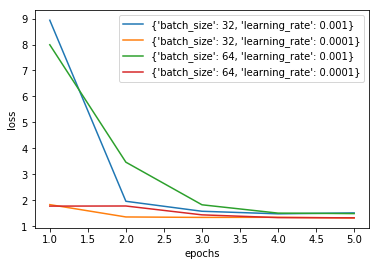

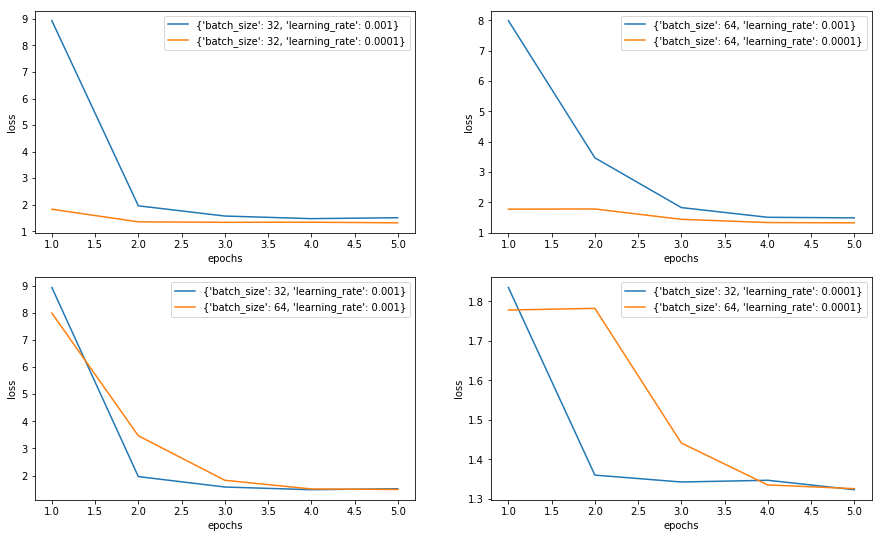


------------ Validation accuracy per epoch at ------------


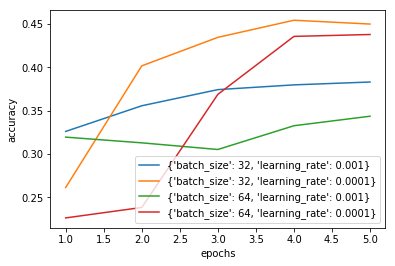

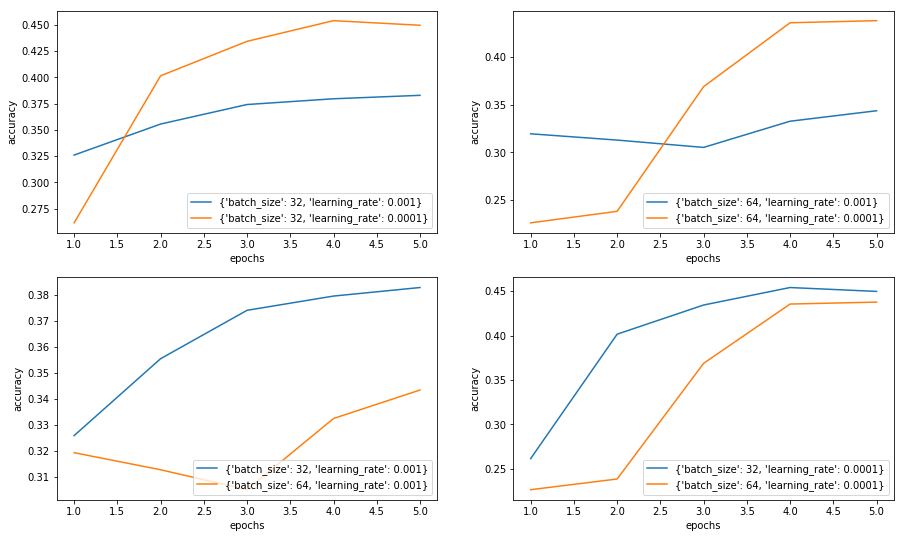

✅ Best Hyperparameters: {'batch_size': 32, 'learning_rate': 0.0001}


In [28]:
best_result = get_best_cv_result(cv_history)
print("✅ Best Hyperparameters:", best_result['params'])

###  Retrain on Full Data with Best Hyperparameters

📊 Training data size: 914

🟢 Epoch 1/10



🔚 Epoch 1/10 — Loss: 3.1062 | Acc: 28.56% | Time: 85.01s

🟢 Epoch 2/10



🔚 Epoch 2/10 — Loss: 1.3797 | Acc: 41.25% | Time: 85.38s

🟢 Epoch 3/10



🔚 Epoch 3/10 — Loss: 1.2499 | Acc: 46.61% | Time: 84.85s

🟢 Epoch 4/10



🔚 Epoch 4/10 — Loss: 1.2129 | Acc: 51.31% | Time: 84.81s

🟢 Epoch 5/10



🔚 Epoch 5/10 — Loss: 1.0952 | Acc: 55.58% | Time: 84.86s

🟢 Epoch 6/10



🔚 Epoch 6/10 — Loss: 1.0280 | Acc: 58.32% | Time: 84.98s

🟢 Epoch 7/10



🔚 Epoch 7/10 — Loss: 0.9395 | Acc: 63.35% | Time: 85.05s

🟢 Epoch 8/10



🔚 Epoch 8/10 — Loss: 0.8603 | Acc: 66.85% | Time: 84.91s

🟢 Epoch 9/10



🔚 Epoch 9/10 — Loss: 0.7661 | Acc: 72.87% | Time: 85.06s

🟢 Epoch 10/10



🔚 Epoch 10/10 — Loss: 0.6608 | Acc: 76.48% | Time: 85.12s

✅ Training complete in 850.04 seconds.


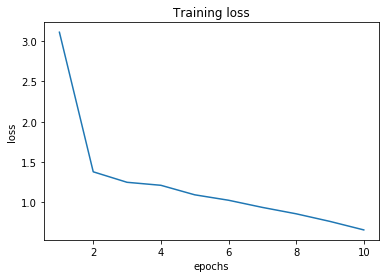

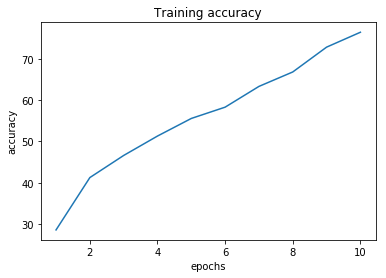

In [29]:
simpleCNN = SimpleCNN(num_classes=num_classes).to(device)
init_state = copy.deepcopy(simpleCNN.state_dict())
trained_model, train_history = train(
    model=simpleCNN,
    epochs=20,
    bs=best_result['params']['batch_size'],
    lr=best_result['params']['learning_rate'],
    init_state=init_state
)

### Final Test Evaluation


🔍 Test dataset size: 346





✅ Test complete in 21.34s
📉 Loss: 0.5697 | 🎯 Accuracy: 87.28%
🔼 Top-3 Accuracy: 98.27%


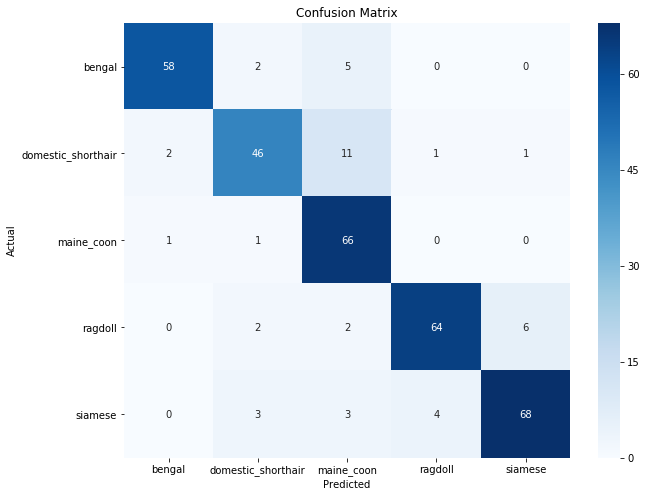

In [30]:
test_loss, test_acc, cm, top3 = test(trained_model, calc_top3_acc=True)
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=data['test'].classes,
            yticklabels=data['test'].classes,
            cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


================= ✅ Best Cross-Validation Result =================
Epoch       : 5
Params      : {'batch_size': 32, 'learning_rate': 0.0001}
Train Loss  : 0.9863
Train Acc   : 62.80%
Valid Loss  : 1.3234
Valid Acc   : 44.97%

------------ Validation loss per epoch ------------


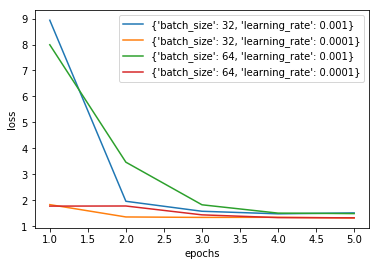

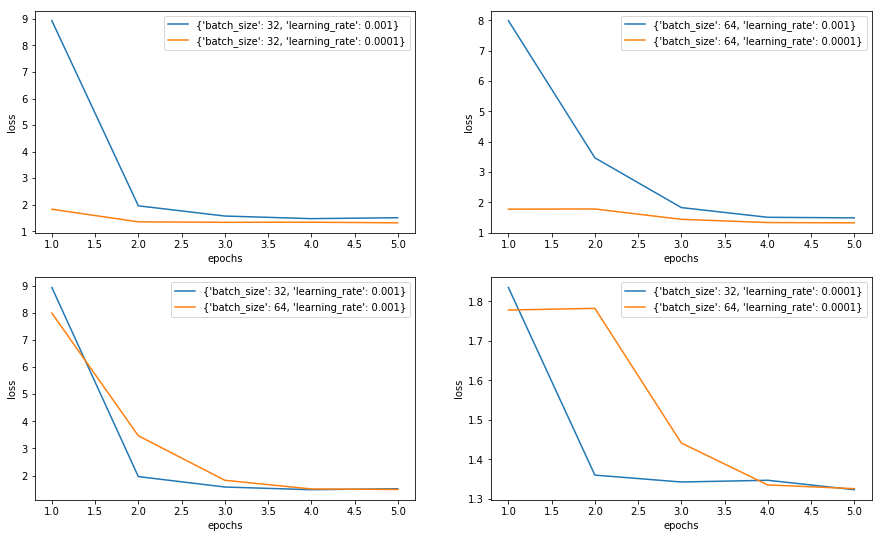


------------ Validation accuracy per epoch at ------------


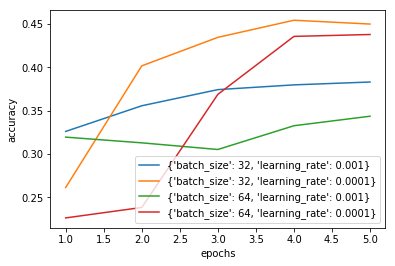

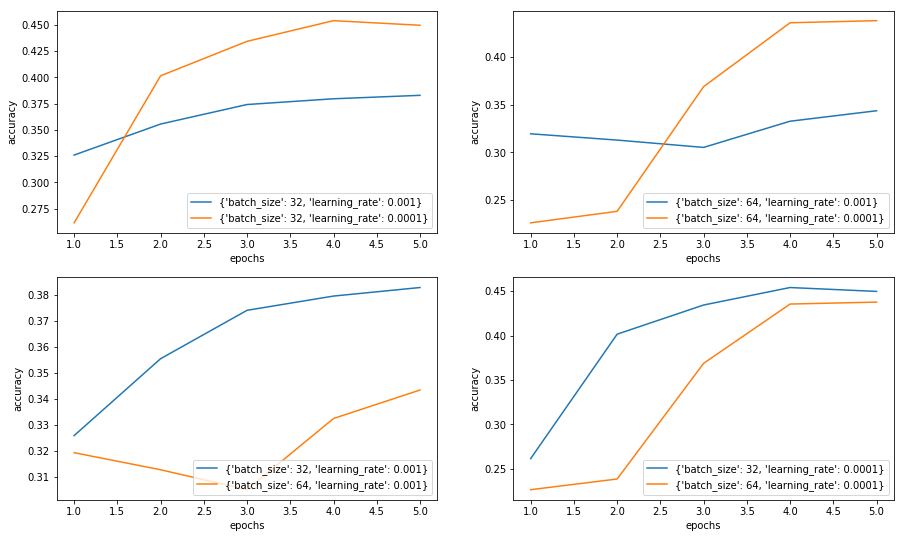

In [31]:
best_cv_result = get_best_cv_result(cv_history)
print("\n================= ✅ Best Cross-Validation Result =================")
print(f"Epoch       : {best_cv_result['epoch']}")
print(f"Params      : {best_cv_result['params']}")
print(f"Train Loss  : {best_cv_result['cv_train_loss']:.4f}")
print(f"Train Acc   : {best_cv_result['cv_train_acc']*100:.2f}%")
print(f"Valid Loss  : {best_cv_result['cv_valid_loss']:.4f}")
print(f"Valid Acc   : {best_cv_result['cv_valid_acc']*100:.2f}%")
print("===================================================================")


================= 📈 Final Training Results =================
Loss       : 0.6608
Accuracy   : 76.48%


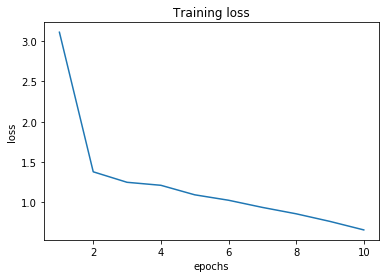

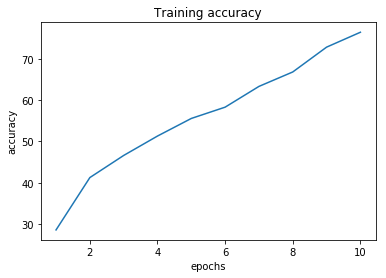

In [32]:
final_loss = train_history[-1]['avg_train_loss']
final_acc = train_history[-1]['avg_train_acc'] * 100
print("\n================= 📈 Final Training Results =================")
print(f"Loss       : {final_loss:.4f}")
print(f"Accuracy   : {final_acc:.2f}%")
print("=============================================================")
plot_train_result(train_history)

In [4]:
results = test(simpleCNN, calc_top3_acc=True)
loss, acc, cm, top3_acc = results
print("\n=================  Test Results =================")
print(f"Test Loss       : {loss:.4f}")
print(f"Test Accuracy   : {acc * 100:.2f}%")
print(f"Top-3 Accuracy  : {top3_acc:.2f}%")
print("===================================================")

NameError: name 'test' is not defined

In [2]:
print('\n------------  F1-Score Per Class ------------')
fscore_df = pd.DataFrame({
    'F1-Score (%)': fscore * 100
}, index=class_names)
display(fscore_df.round(2))  


------------ 🎯 F1-Score Per Class ------------


NameError: name 'pd' is not defined

In [71]:
import os
os.makedirs("model", exist_ok=True)
save_model_state(simpleCNN, 'model/simpleCNN-model.pth')
print("✅ Model saved successfully to: model/simpleCNN-model.pth")

✅ Model saved successfully to: model/simpleCNN-model.pth


### ResNet-50

### Load and Modify ResNet-50

In [76]:
import torchvision.models as models
resnet50 = models.resnet50(pretrained=True)
for param in resnet50.parameters():
    param.requires_grad = False
num_classes = len(data['train'].classes) 
fc_inputs = resnet50.fc.in_features

resnet50.fc = nn.Sequential(
    nn.Linear(fc_inputs, num_classes),
    nn.LogSoftmax(dim=1)  
)
resnet50 = resnet50.to(device)
init_state = copy.deepcopy(resnet50.state_dict())
print("ResNet-50 loaded, modified, frozen, and ready.")

✅ ResNet-50 loaded, modified, frozen, and ready.


### Grid Search with Cross-Validation

In [ ]:
cv_history = grid_search_cv(
    resnet50,
    k_fold=5,
    epochs=10,
    hyperparameters={
        'batch_size': [32, 64],
        'learning_rate': [1e-3, 1e-4]
    }
)

NameError: name 'grid_search_cv' is not defined


================= ✅ Best Cross-Validation Result =================
Epoch           : 5
Params          : {'batch_size': 32, 'learning_rate': 0.001}
Train Loss      : 0.5061
Train Accuracy  : 83.70%
Valid Loss      : 0.4971
Valid Accuracy  : 83.92%

------------ Validation loss per epoch ------------


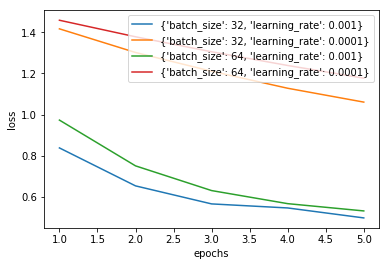

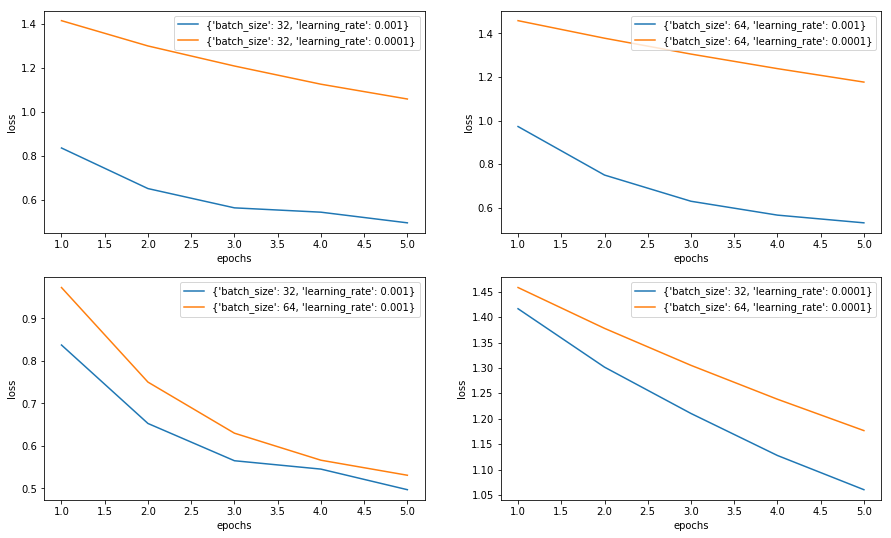


------------ Validation accuracy per epoch at ------------


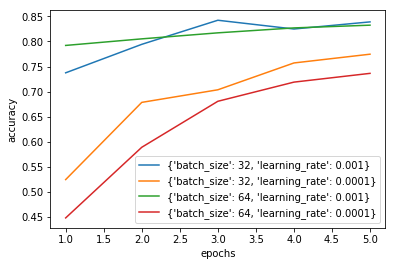

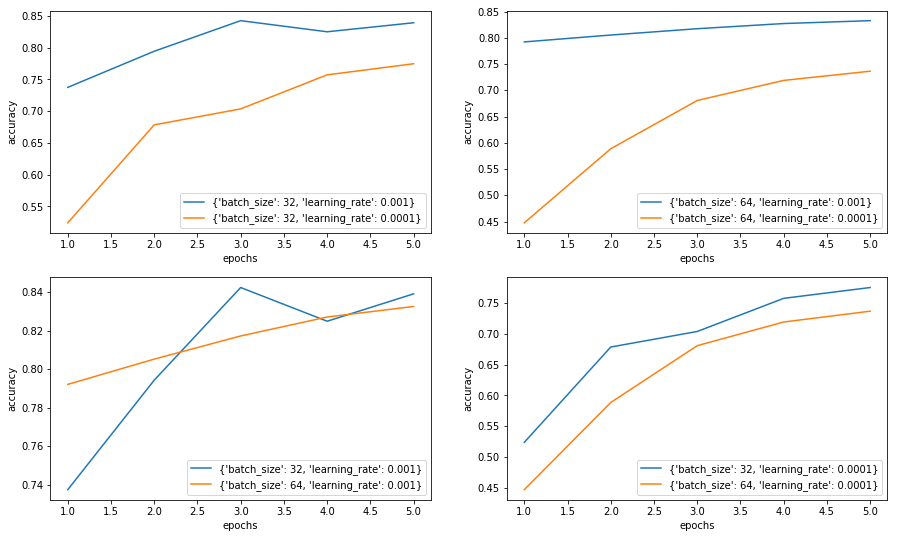

In [78]:
best_cv_result = get_best_cv_result(cv_history)
print("\n=================  Best Cross-Validation Result =================")
print(f"Epoch           : {best_cv_result['epoch']}")
print(f"Params          : {best_cv_result['params']}")
print(f"Train Loss      : {best_cv_result['cv_train_loss']:.4f}")
print(f"Train Accuracy  : {best_cv_result['cv_train_acc'] * 100:.2f}%")
print(f"Valid Loss      : {best_cv_result['cv_valid_loss']:.4f}")
print(f"Valid Accuracy  : {best_cv_result['cv_valid_acc'] * 100:.2f}%")
print("===================================================================")
plot_cv_result(cv_history)

### Retrain ResNet-50 on Full Dataset

📊 Training data size: 914

🟢 Epoch 1/5



🔚 Epoch 1/5 — Loss: 1.0797 | Acc: 60.94% | Time: 108.18s

🟢 Epoch 2/5



🔚 Epoch 2/5 — Loss: 0.6383 | Acc: 79.21% | Time: 108.62s

🟢 Epoch 3/5



🔚 Epoch 3/5 — Loss: 0.5136 | Acc: 84.79% | Time: 108.61s

🟢 Epoch 4/5



🔚 Epoch 4/5 — Loss: 0.4603 | Acc: 85.23% | Time: 108.62s

🟢 Epoch 5/5



🔚 Epoch 5/5 — Loss: 0.4269 | Acc: 85.12% | Time: 108.68s

✅ Training complete in 542.71 seconds.


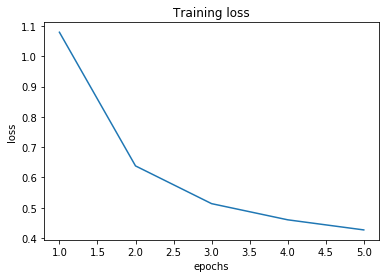

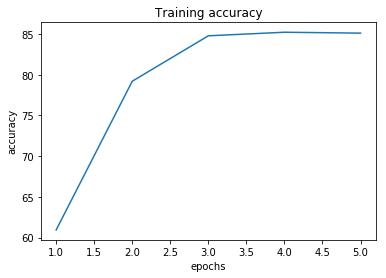


================= 📈 Final Training Results =================
Loss       : 0.4269
Accuracy   : 85.12%


In [80]:
resnet50.load_state_dict(init_state)

resnet50, train_history = train(
    model=resnet50,
    epochs=best_cv_result['epoch'],
    bs=best_cv_result['params']['batch_size'],
    lr=best_cv_result['params']['learning_rate'],
    init_state=init_state
)

# 📈 Plot final training performance
plot_train_result(train_history)
final_loss = train_history[-1]['avg_train_loss']
final_acc = train_history[-1]['avg_train_acc'] * 100

print("\n================= 📈 Final Training Results =================")
print(f"Loss       : {final_loss:.4f}")
print(f"Accuracy   : {final_acc:.2f}%")
print("=============================================================")


###  Per-Class Metrics (Precision, Recall, F1)

In [82]:
results = test(resnet50, calc_top3_acc=True)
loss, acc, cm, top3_acc = results
recall = cm.diagonal() / cm.sum(axis=1)
precision = cm.diagonal() / cm.sum(axis=0)
fscore = 2 * precision * recall / (precision + recall)
recall = np.nan_to_num(recall)
precision = np.nan_to_num(precision)
fscore = np.nan_to_num(fscore)

# 🖨️ Print main test metrics
print("\n================= 📊 Final Evaluation Metrics =================")
print(f"🔹 Test Loss        : {loss:.4f}")
print(f" Test Accuracy    : {acc * 100:.2f}%")
print(f" Top-3 Accuracy   : {top3_acc:.2f}%")
print(f" Avg. F1-Score    : {np.mean(fscore) * 100:.2f}%")
print("===============================================================")



🔍 Test dataset size: 346





✅ Test complete in 40.49s
📉 Loss: 0.3802 | 🎯 Accuracy: 87.86%
🔼 Top-3 Accuracy: 99.42%

================= 🧪 ResNet-50 Test Results =================
🔹 Test Loss         : 0.3802
✅ Test Accuracy     : 87.86%
🔼 Top-3 Accuracy    : 99.42%



------------ 📉 Confusion Matrix ------------


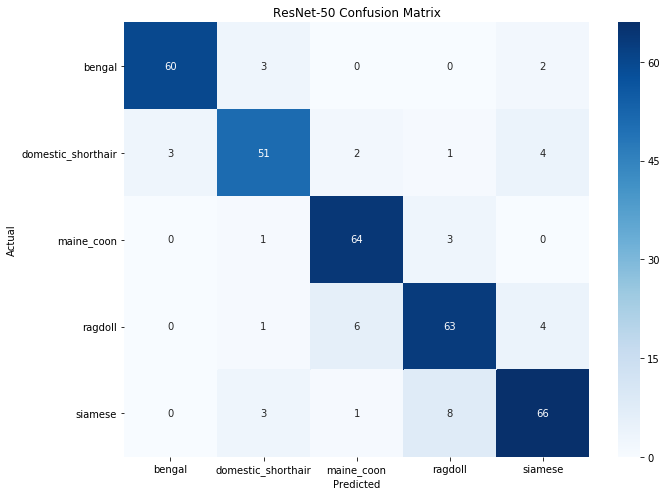

In [84]:
print('\n------------ 📉 Confusion Matrix ------------')

df_cm = pd.DataFrame(cm, 
                     index=data['test'].class_to_idx.keys(),
                     columns=data['test'].class_to_idx.keys())

plt.figure(figsize=(10, 7))
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("ResNet-50 Confusion Matrix")
plt.tight_layout()
plt.show()


In [85]:
import os
os.makedirs("model", exist_ok=True)
save_model_state(resnet50, 'model/resnet50-model.pth')
print("✅ ResNet-50 model saved to: model/resnet50-model.pth")

✅ ResNet-50 model saved to: model/resnet50-model.pth


 ### **ResNet-50 with Augmentation**

In [86]:
import torch
import torch.nn as nn
import torchvision
import copy
resnet50 = torchvision.models.resnet50(pretrained=True)
for param in resnet50.parameters():
    param.requires_grad = False
fc_inputs = resnet50.fc.in_features
resnet50.fc = nn.Sequential(
    nn.Linear(fc_inputs, 5),  
    nn.LogSoftmax(dim=1)     
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50 = resnet50.to(device)
init_state = copy.deepcopy(resnet50.state_dict())
print(" ResNet50 is ready for 5-class classification!")

✅ ResNet50 is ready for 5-class classification!


### **Grid Search with Augmented Data** 

In [87]:
cv_history = grid_search_cv(
    resnet50,
    k_fold=5,
    epochs=10,
    hyperparameters={'batch_size':[32,64], 'learning_rate' : [1e-03, 1e-04]},
    transforms=augmented_image_transforms
)

🔧 Hyperparameters 1/4 — Batch Size: 32, LR: 0.001
📁 Fold 1/3 — Train size: 607, Valid size: 307

📈 Epoch 1/5
🔹 Train Loss: 1.2525 | Acc: 0.4942
🔸 Valid Loss: 0.8253 | Acc: 0.7785

📈 Epoch 2/5
🔹 Train Loss: 0.7457 | Acc: 0.7809
🔸 Valid Loss: 0.6119 | Acc: 0.8306

📈 Epoch 3/5
🔹 Train Loss: 0.5951 | Acc: 0.8023
🔸 Valid Loss: 0.4858 | Acc: 0.8795

📈 Epoch 4/5
🔹 Train Loss: 0.5123 | Acc: 0.8303
🔸 Valid Loss: 0.4631 | Acc: 0.8730

📈 Epoch 5/5
🔹 Train Loss: 0.4621 | Acc: 0.8534
🔸 Valid Loss: 0.4649 | Acc: 0.8534
📁 Fold 2/3 — Train size: 609, Valid size: 305

📈 Epoch 1/5
🔹 Train Loss: 1.2214 | Acc: 0.5238
🔸 Valid Loss: 0.8291 | Acc: 0.7836

📈 Epoch 2/5
🔹 Train Loss: 0.8061 | Acc: 0.7258
🔸 Valid Loss: 0.7019 | Acc: 0.7574

📈 Epoch 3/5
🔹 Train Loss: 0.6023 | Acc: 0.8259
🔸 Valid Loss: 0.6096 | Acc: 0.7738

📈 Epoch 4/5
🔹 Train Loss: 0.5636 | Acc: 0.8194
🔸 Valid Loss: 0.6044 | Acc: 0.7607

📈 Epoch 5/5
🔹 Train Loss: 0.5604 | Acc: 0.7833
🔸 Valid Loss: 0.6752 | Acc: 0.7311
📁 Fold 3/3 — Train size: 612


------------ Best cross validation result ------------
{'params': {'batch_size': 64, 'learning_rate': 0.001}, 'epoch': 5, 'cv_train_acc': 0.8550328227571116, 'cv_train_loss': 0.5139464473828705, 'cv_valid_acc': 0.8358862144420132, 'cv_valid_loss': 0.5374887694219531}

------------ Validation loss per epoch ------------


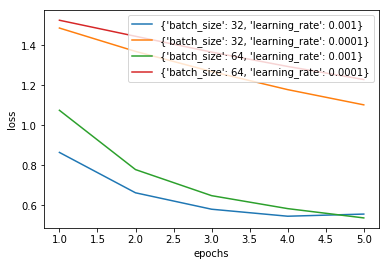

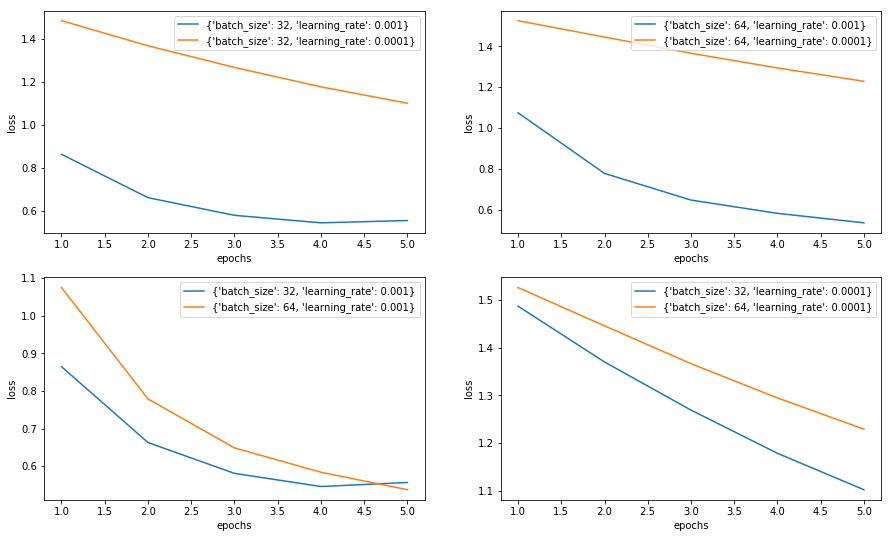


------------ Validation accuracy per epoch at ------------


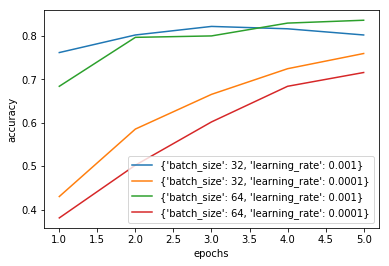

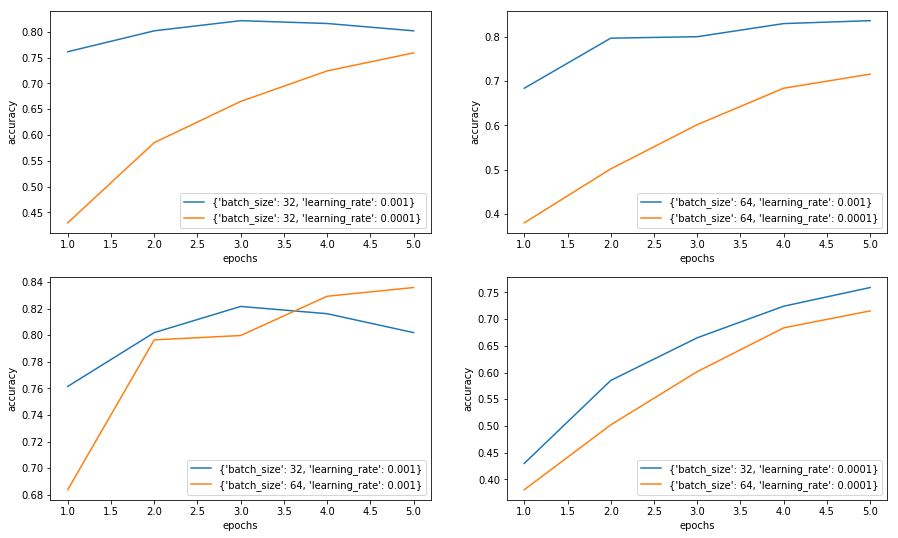

In [89]:
best_cv_result = get_best_cv_result(cv_history)
print('\n------------ Best cross validation result ------------')
print(best_cv_result)
plot_cv_result(cv_history)


### **Retrain Using Best Params (Augmented)**

In [90]:
resnet50, train_history = train(
    resnet50,
    best_cv_result['epoch'],
    best_cv_result['params']['batch_size'],
    best_cv_result['params']['learning_rate'],
    init_state,
    transforms=augmented_image_transforms
)
print('Final Training Loss :', train_history[-1]['avg_train_loss'])
print('Final Training Accuracy :', train_history[-1]['avg_train_acc'] * 100, "%")
plot_train_result(train_history)

📊 Training data size: 914

🟢 Epoch 1/5



🔚 Epoch 1/5 — Loss: 1.0773 | Acc: 65.43% | Time: 105.89s

🟢 Epoch 2/5



🔚 Epoch 2/5 — Loss: 0.7087 | Acc: 79.10% | Time: 106.47s

🟢 Epoch 3/5



🔚 Epoch 3/5 — Loss: 0.5631 | Acc: 83.48% | Time: 107.36s

🟢 Epoch 4/5



🔚 Epoch 4/5 — Loss: 0.5270 | Acc: 83.15% | Time: 105.05s

🟢 Epoch 5/5



🔚 Epoch 5/5 — Loss: 0.5081 | Acc: 82.93% | Time: 106.53s

✅ Training complete in 531.32 seconds.


### **Test the Model**

In [92]:
results = test(resnet50, calc_top3_acc=True)
loss = results[0]
acc = results[1]
cm = results[2]
top3_acc = results[3]



🔍 Test dataset size: 346





✅ Test complete in 38.72s
📉 Loss: 0.4566 | 🎯 Accuracy: 85.55%
🔼 Top-3 Accuracy: 99.13%


### **Classification Metrics + Confusion Matrix**

Test Loss : 0.456594081800108
Test Accuracy : 85.54913294797689
Average F1-Score : 85.48713446077
Top-3 Accuracy : 9913.29479768786

------------ Confusion Matrix ------------


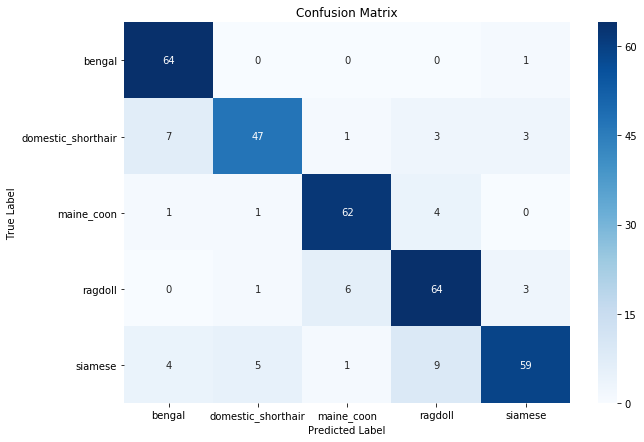


------------ F1-Score per Class ------------


,F1-Score
bengal,0.907801
domestic_shorthair,0.817391
maine_coon,0.898551
ragdoll,0.831169
siamese,0.819444


In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
recall = cm.diagonal() / cm.sum(axis=1)
precision = cm.diagonal() / cm.sum(axis=0)
fscore = 2 * precision * recall / (precision + recall)
print('Test Loss :', loss)
print('Test Accuracy :', acc * 100)
print('Average F1-Score :', np.average(fscore) * 100)
print('Top-3 Accuracy :', top3_acc * 100)
print('\n------------ Confusion Matrix ------------')
idx_to_class = {v: k for k, v in data['test'].class_to_idx.items()}
labels = list(idx_to_class.values())
df_cm = pd.DataFrame(cm, index=labels, columns=labels)
plt.figure(figsize=(10, 7))
sn.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()
print('\n------------ F1-Score per Class ------------')
fscore_df = pd.DataFrame(fscore, index=labels, columns=['F1-Score'])
display(fscore_df)

In [94]:
save_model_state(resnet50, 'model/resnet50-model-augmentation.pth')

A subdirectory or file model already exists.


### **Predict on Sample Images**

In [95]:
import torchvision
import torch.nn as nn
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50 = torchvision.models.resnet50(pretrained=True)
for param in resnet50.parameters():
    param.requires_grad = False
fc_inputs = resnet50.fc.in_features
resnet50.fc = nn.Sequential(
    nn.Linear(fc_inputs, 5), 
    nn.LogSoftmax(dim=1)      
)
resnet50 = load_model_state(resnet50, 'model/resnet50-model-augmentation.pth')
print(" Model loaded successfully!")

✅ Model loaded successfully!


In [96]:
import torch
from PIL import Image
import matplotlib.pyplot as plt

def predict(model, img, k, actual_label):
    if isinstance(img, str):
        predict_image = Image.open(img).convert('RGB')
    else:
        predict_image = img

    transform = image_transforms['test']
    predict_image_tensor = transform(predict_image).unsqueeze(0) 
    predict_image_tensor = predict_image_tensor.to(device)

    model.eval()
    with torch.no_grad():
        out = model(predict_image_tensor)
        ps = torch.exp(out) 

        
        topprob, topclass = ps.topk(k, dim=1)
        topprob_np = topprob.cpu().numpy()[0]
        topclass_np = topclass.cpu().numpy()[0]

  
    print('Actual Label:')
    print('-', actual_label, '\n')
    print(f'Top {k} Predictions:')
    for idx, prob in enumerate(topprob_np):
        print(f"- {idx_to_class[topclass_np[idx]]} : {prob*100:.2f}%")

    plt.figure()
    plt.imshow(predict_image)
    plt.axis('off')
    plt.show()
    print('------------------------------------------------------')
    
predict(resnet50, r'C:\deep1\cat_v1_split\test\bengal\00e79f939696ea0c095603154c4af840.jpg', k=3, actual_label='bengal')
predict(resnet50, r'C:\deep1\cat_v1_split\test\domestic_shorthair\European_shorthair_cat_portrait.jpg', k=3, actual_label='domestic_shorthair')
predict(resnet50, r'C:\deep1\cat_v1_split\test\maine_coon\df395c98913b468cfabc7cbc25cdb203.jpg', k=3, actual_label='maine_coon')
predict(resnet50, r'C:\deep1\cat_v1_split\test\ragdoll\86 (1).jpg', k=3, actual_label='ragdoll')
predict(resnet50, r'C:\deep1\cat_v1_split\test\siamese\7dd1f4062460fc0b4208eb7b65d6c694.jpg', k=3, actual_label='siamese')


### **❌ Show Top Misclassifications**

In [103]:
idx_to_class = {val: key for key, val in data['test'].class_to_idx.items()}

misclass = []
for i in range(len(cm)):
    for j in range(len(cm[i])):
        if i!=j:
            misclass.append([idx_to_class[i],idx_to_class[j], cm[i][j]])

df_misclass = pd.DataFrame(misclass,columns=['actual','prediction','count'])
df_misclass = df_misclass.sort_values(by=['count'], ascending=False)
df_misclass.head(3)


,actual,prediction,count
19,siamese,ragdoll,9
4,domestic_shorthair,bengal,7
14,ragdoll,maine_coon,6


In [7]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

def load_model_state(model, path):
    model.load_state_dict(torch.load(path))
    model = model.to(device)
    return model

# 1. SimpleCNN
simpleCNN = SimpleCNN(num_classes=5).to(device)
simpleCNN = load_model_state(simpleCNN, 'model/simpleCNN-model.pth')

# 2. ResNet-50 (no augmentation)
resnet50_no_aug = torchvision.models.resnet50(pretrained=True)
for param in resnet50_no_aug.parameters():
    param.requires_grad = False
fc_inputs = resnet50_no_aug.fc.in_features
resnet50_no_aug.fc = nn.Sequential(nn.Linear(fc_inputs, 5), nn.LogSoftmax(dim=1))
resnet50_no_aug = load_model_state(resnet50_no_aug, 'model/resnet50-model.pth')

# 3. ResNet-50 (with augmentation)
resnet50_aug = torchvision.models.resnet50(pretrained=True)
for param in resnet50_aug.parameters():
    param.requires_grad = False
fc_inputs = resnet50_aug.fc.in_features
resnet50_aug.fc = nn.Sequential(nn.Linear(fc_inputs, 5), nn.LogSoftmax(dim=1))
resnet50_aug = load_model_state(resnet50_aug, 'model/resnet50-model-augmentation.pth')

print("\n All 3 models loaded successfully!")



 All 3 models loaded successfully!


### **Augmented Inputs Visualization and Prediction**



===================== Original =====================


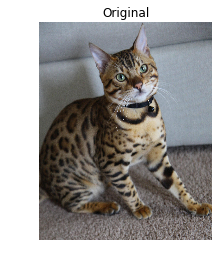

🔹 SimpleCNN:
   1. Maine Coon (73.20%)
   2. Ragdoll (21.24%)
   3. Siamese (3.16%)
------------------------------------------------------
🔹 ResNet50 (no augmentation):
   1. Bengal (99.00%)
   2. Siamese (0.54%)
   3. Persian (0.33%)
------------------------------------------------------
🔹 ResNet50 (with augmentation):
   1. Bengal (99.45%)
   2. Siamese (0.31%)
   3. Persian (0.15%)
------------------------------------------------------


===================== Horizontal Flip =====================


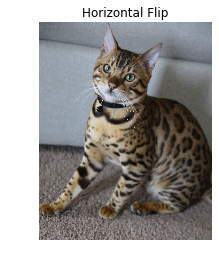

🔹 SimpleCNN:
   1. Maine Coon (75.04%)
   2. Ragdoll (19.34%)
   3. Siamese (3.53%)
------------------------------------------------------
🔹 ResNet50 (no augmentation):
   1. Bengal (98.70%)
   2. Siamese (0.71%)
   3. Persian (0.46%)
------------------------------------------------------
🔹 ResNet50 (with augmentation):
   1. Bengal (99.10%)
   2. Siamese (0.56%)
   3. Persian (0.22%)
------------------------------------------------------


===================== Vertical Flip =====================


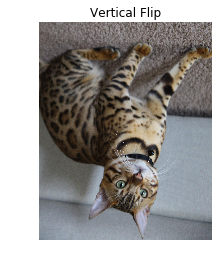

🔹 SimpleCNN:
   1. Maine Coon (74.94%)
   2. Ragdoll (20.46%)
   3. Siamese (2.58%)
------------------------------------------------------
🔹 ResNet50 (no augmentation):
   1. Bengal (67.40%)
   2. Siamese (18.74%)
   3. Maine Coon (5.86%)
------------------------------------------------------
🔹 ResNet50 (with augmentation):
   1. Bengal (85.77%)
   2. Siamese (6.77%)
   3. Persian (2.93%)
------------------------------------------------------


===================== Darker =====================


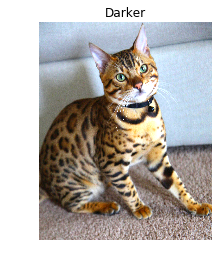

🔹 SimpleCNN:
   1. Maine Coon (65.42%)
   2. Ragdoll (25.98%)
   3. Siamese (4.75%)
------------------------------------------------------
🔹 ResNet50 (no augmentation):
   1. Bengal (99.25%)
   2. Siamese (0.46%)
   3. Persian (0.18%)
------------------------------------------------------
🔹 ResNet50 (with augmentation):
   1. Bengal (99.56%)
   2. Siamese (0.30%)
   3. Persian (0.06%)
------------------------------------------------------


===================== Brighter =====================


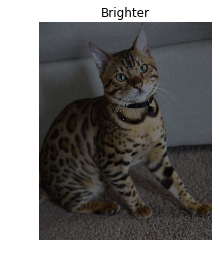

🔹 SimpleCNN:
   1. Maine Coon (75.40%)
   2. Ragdoll (20.21%)
   3. Siamese (2.42%)
------------------------------------------------------
🔹 ResNet50 (no augmentation):
   1. Bengal (82.78%)
   2. Persian (7.82%)
   3. Siamese (6.91%)
------------------------------------------------------
🔹 ResNet50 (with augmentation):
   1. Bengal (92.66%)
   2. Siamese (3.38%)
   3. Persian (2.70%)
------------------------------------------------------


===================== Lower Contrast =====================


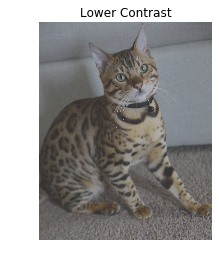

🔹 SimpleCNN:
   1. Maine Coon (76.71%)
   2. Ragdoll (19.37%)
   3. Siamese (2.34%)
------------------------------------------------------
🔹 ResNet50 (no augmentation):
   1. Bengal (88.96%)
   2. Persian (5.07%)
   3. Siamese (4.49%)
------------------------------------------------------
🔹 ResNet50 (with augmentation):
   1. Bengal (94.85%)
   2. Siamese (2.34%)
   3. Persian (1.91%)
------------------------------------------------------


===================== Higher Contrast =====================


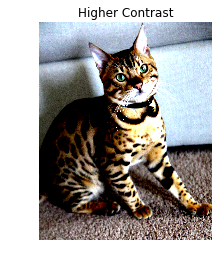

🔹 SimpleCNN:
   1. Maine Coon (52.04%)
   2. Ragdoll (30.99%)
   3. Persian (8.06%)
------------------------------------------------------
🔹 ResNet50 (no augmentation):
   1. Bengal (99.34%)
   2. Siamese (0.53%)
   3. Persian (0.10%)
------------------------------------------------------
🔹 ResNet50 (with augmentation):
   1. Bengal (99.31%)
   2. Siamese (0.59%)
   3. Persian (0.06%)
------------------------------------------------------


===================== Add Noise =====================


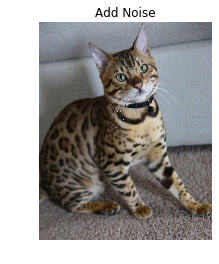

🔹 SimpleCNN:
   1. Maine Coon (73.20%)
   2. Ragdoll (21.23%)
   3. Siamese (3.16%)
------------------------------------------------------
🔹 ResNet50 (no augmentation):
   1. Bengal (98.97%)
   2. Siamese (0.55%)
   3. Persian (0.34%)
------------------------------------------------------
🔹 ResNet50 (with augmentation):
   1. Bengal (99.43%)
   2. Siamese (0.32%)
   3. Persian (0.16%)
------------------------------------------------------


===================== Rotate =====================


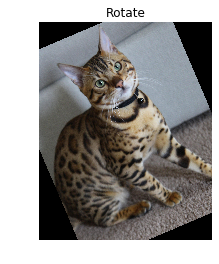

🔹 SimpleCNN:
   1. Maine Coon (76.20%)
   2. Ragdoll (18.81%)
   3. Siamese (2.88%)
------------------------------------------------------
🔹 ResNet50 (no augmentation):
   1. Bengal (40.18%)
   2. Persian (26.52%)
   3. Siamese (20.30%)
------------------------------------------------------
🔹 ResNet50 (with augmentation):
   1. Bengal (75.87%)
   2. Siamese (8.49%)
   3. Persian (8.33%)
------------------------------------------------------


===================== All Transforms Combined =====================


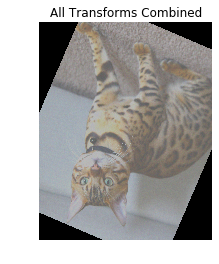

🔹 SimpleCNN:
   1. Maine Coon (80.38%)
   2. Ragdoll (15.81%)
   3. Siamese (2.52%)
------------------------------------------------------
🔹 ResNet50 (no augmentation):
   1. Siamese (34.56%)
   2. Bengal (25.59%)
   3. Persian (18.76%)
------------------------------------------------------
🔹 ResNet50 (with augmentation):
   1. Bengal (57.28%)
   2. Siamese (21.76%)
   3. Persian (9.03%)
------------------------------------------------------


In [8]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter

# ====== DEVICE CONFIG ======
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ====== CONVERSION TOOLS ======
to_tensor = transforms.ToTensor()
to_pil = transforms.ToPILImage()

# ====== CUSTOM TRANSFORMS ======
def add_noise(img, std=0.01):
    t = to_tensor(img)
    noise = torch.randn_like(t) * std
    return to_pil(torch.clamp(t + noise, 0., 1.))

# ====== TRANSFORM DEFINITIONS ======
transformations = {
    'Original': lambda x: x,
    'Horizontal Flip': transforms.RandomHorizontalFlip(p=1),
    'Vertical Flip': transforms.RandomVerticalFlip(p=1),
    'Darker': transforms.ColorJitter(brightness=0.5, saturation=0.8),
    'Brighter': transforms.ColorJitter(brightness=1.5),
    'Lower Contrast': transforms.ColorJitter(contrast=0.5),
    'Higher Contrast': transforms.ColorJitter(contrast=1.5),
    'Add Noise': lambda x: add_noise(x, std=0.01),
    'Rotate': transforms.RandomRotation(30)
}

# ====== CHAINED COMBINATION TRANSFORM ======
def combined_transform(img):
    sequential = transforms.Compose([
        transforms.RandomHorizontalFlip(p=1),
        transforms.RandomVerticalFlip(p=1),
        transforms.ColorJitter(brightness=0.5, saturation=0.8),
        transforms.ColorJitter(brightness=1.5),
        transforms.ColorJitter(contrast=0.5),
        transforms.ColorJitter(contrast=1.5),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: torch.clamp(x + torch.randn_like(x) * 0.01, 0., 1.)),
        transforms.ToPILImage(),
        transforms.RandomRotation(30)
    ])
    return sequential(img)

# ====== LOAD ORIGINAL IMAGE ======
img_path = r'C:\deep1\cat_v1_split\test\bengal\00e79f939696ea0c095603154c4af840.jpg'
ori_img = Image.open(img_path).convert("RGB")

# ====== APPLY INDIVIDUAL TRANSFORMS ======
transformed_imgs = {'Original': ori_img}
for name, transform in transformations.items():
    transformed_imgs[name] = transform(ori_img)
transformed_imgs['All Transforms Combined'] = combined_transform(ori_img)

# ====== IMAGE PREPROCESSING FOR MODEL ======
image_transforms = {
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
}

# ====== DUMMY CLASS MAP (REPLACE WITH YOURS) ======
idx_to_class = {0: 'Bengal', 1: 'Siamese', 2: 'Persian', 3: 'Maine Coon', 4: 'Ragdoll'}

# ====== PREDICTION FUNCTION ======
def predict_from_img(model, img, k=3):
    model.eval()
    img_tensor = image_transforms['test'](img).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(img_tensor)
        probs = torch.exp(outputs)
        top_probs, top_classes = probs.topk(k, dim=1)
    preds = [idx_to_class[c] for c in top_classes[0].cpu().numpy()]
    prob_values = top_probs[0].cpu().numpy()
    return preds, prob_values

# ====== MODELS TO TEST ======
models_to_compare = {
    'SimpleCNN': simpleCNN,
    'ResNet50 (no augmentation)': resnet50_no_aug,
    'ResNet50 (with augmentation)': resnet50_aug
}

# ====== VISUALIZE & RUN PREDICTIONS ======
for name, img in transformed_imgs.items():
    print(f"\n\n===================== {name} =====================")
    plt.imshow(img)
    plt.axis('off')
    plt.title(name)
    plt.show()

    for model_name, model in models_to_compare.items():
        preds, probs = predict_from_img(model, img)
        print(f"🔹 {model_name}:")
        for i, (p, prob) in enumerate(zip(preds, probs)):
            print(f"   {i+1}. {p} ({prob * 100:.2f}%)")
        print("------------------------------------------------------")
